In [2]:
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd 
import numpy as np 
import time, random, re, csv
import statsmodels.api as sm
import seaborn as sns 
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.model_selection import (cross_val_score, train_test_split, KFold, GridSearchCV)
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt 
import scipy.stats as stats

In [3]:
LDF = pd.read_csv("/Users/che-yuliu/Desktop/listings.csv")
LDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1204 entries, 0 to 1203
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   address            1204 non-null   object 
 1   price              1204 non-null   int64  
 2   bedrooms           1204 non-null   object 
 3   baths              1204 non-null   object 
 4   square_ft          1204 non-null   object 
 5   total_time_listed  1144 non-null   object 
 6   property_type      1147 non-null   object 
 7   year_built         915 non-null    float64
 8   hoa_dues           286 non-null    object 
 9   community          1138 non-null   object 
 10  lot_size           1065 non-null   object 
 11  price/sqft         957 non-null    object 
dtypes: float64(1), int64(1), object(10)
memory usage: 113.0+ KB


__Cleaning the data__

In [11]:
LDF.drop(LDF.index[1146:], inplace = True)

In [12]:
LDF.columns = LDF.columns.str.upper()
LDF["COMMUNITY"] = LDF.COMMUNITY.str.upper()
LDF.head()

,ADDRESS,PRICE,BEDROOMS,BATHS,SQUARE_FT,TOTAL_TIME_LISTED,PROPERTY_TYPE,YEAR_BUILT,HOA_DUES,COMMUNITY,LOT_SIZE,PRICE/SQFT
0,11643 Silvergate Dr,1690000,4,2,1888,23 hours,Single Family Residential,1968.0,NaN,DUBLIN,"7,153 Sq. Ft.",$895
1,7806 Peachtree Ave,1249888,3,2.5,1356,26 hours,Single Family Residential,1971.0,NaN,NEWARK,"6,000 Sq. Ft.",$922
2,38746 Buckboard Cmn,1298000,3,2.5,1780,2 days,Single Family Home,1988.0,$91,FREMONT,"3,348 Sq. Ft.",$729
3,564 Olivina Ave,850000,4,2,1268,2 days,Single Family Residential,1971.0,NaN,LIVERMORE,"7,224 Sq. Ft.",$670
4,1970 Barton Way,1125000,4,2.5,1751,3 days,Single Family Residential,1992.0,NaN,HAYWARD,"3,500 Sq. Ft.",$642


In [13]:
LDF = LDF.replace("—", np.NaN)
LDF.iloc[101]

ADDRESS              29 - A Wildlife Trl
PRICE                              65000
BEDROOMS                             NaN
BATHS                                NaN
SQUARE_FT                           7.02
TOTAL_TIME_LISTED                 5 days
PROPERTY_TYPE                Vacant Land
YEAR_BUILT                           NaN
HOA_DUES                        $4/month
COMMUNITY                     FIDDLETOWN
LOT_SIZE                      7.02 Acres
PRICE/SQFT                           NaN
Name: 101, dtype: object

In [14]:
# Converting numerical values into floats 
LDF = LDF.astype({"BEDROOMS" : float, "BATHS" : float, "SQUARE_FT" : float})


In [15]:
LDF = LDF.replace(".....Please Select", np.NaN)
LDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1146 entries, 0 to 1145
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ADDRESS            1146 non-null   object 
 1   PRICE              1146 non-null   int64  
 2   BEDROOMS           954 non-null    float64
 3   BATHS              957 non-null    float64
 4   SQUARE_FT          1129 non-null   float64
 5   TOTAL_TIME_LISTED  1144 non-null   object 
 6   PROPERTY_TYPE      1146 non-null   object 
 7   YEAR_BUILT         914 non-null    float64
 8   HOA_DUES           286 non-null    object 
 9   COMMUNITY          1138 non-null   object 
 10  LOT_SIZE           1064 non-null   object 
 11  PRICE/SQFT         956 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 107.6+ KB


In [16]:
LDF.rename(columns = {"PRICE/SQFT" : "PRICE_PER_SQFT"}, inplace = True)
LDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1146 entries, 0 to 1145
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ADDRESS            1146 non-null   object 
 1   PRICE              1146 non-null   int64  
 2   BEDROOMS           954 non-null    float64
 3   BATHS              957 non-null    float64
 4   SQUARE_FT          1129 non-null   float64
 5   TOTAL_TIME_LISTED  1144 non-null   object 
 6   PROPERTY_TYPE      1146 non-null   object 
 7   YEAR_BUILT         914 non-null    float64
 8   HOA_DUES           286 non-null    object 
 9   COMMUNITY          1138 non-null   object 
 10  LOT_SIZE           1064 non-null   object 
 11  PRICE_PER_SQFT     956 non-null    object 
dtypes: float64(4), int64(1), object(7)
memory usage: 107.6+ KB


In [17]:
LDF["PRICE_PER_SQFT"] = LDF.PRICE_PER_SQFT.str.replace("$", "")

/var/folders/c3/70y7ct457z7_9cv9bcgyx8sc0000gn/T/ipykernel_1026/1562034047.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  LDF["PRICE_PER_SQFT"] = LDF.PRICE_PER_SQFT.str.replace("$", "")


In [18]:
LDF["PRICE_PER_SQFT"] = LDF.PRICE_PER_SQFT.str.replace(",", "")

In [231]:
LDF.head()

,ADDRESS,PRICE,BEDROOMS,BATHS,SQUARE_FT,TOTAL_TIME_LISTED,PROPERTY_TYPE,YEAR_BUILT,HOA_DUES,COMMUNITY,LOT_SIZE,PRICE_PER_SQFT
0,11643 Silvergate Dr,1690000,4.0,2.0,1888.0,23 hours,Single Family Residential,1968.0,NaN,DUBLIN,"7,153 Sq. Ft.",895.0
1,7806 Peachtree Ave,1249888,3.0,2.5,1356.0,26 hours,Single Family Residential,1971.0,NaN,NEWARK,"6,000 Sq. Ft.",922.0
2,38746 Buckboard Cmn,1298000,3.0,2.5,1780.0,2 days,Single Family Home,1988.0,91.0,FREMONT,"3,348 Sq. Ft.",729.0
3,564 Olivina Ave,850000,4.0,2.0,1268.0,2 days,Single Family Residential,1971.0,NaN,LIVERMORE,"7,224 Sq. Ft.",670.0
4,1970 Barton Way,1125000,4.0,2.5,1751.0,3 days,Single Family Residential,1992.0,NaN,HAYWARD,"3,500 Sq. Ft.",642.0


In [20]:
LDF["HOA_DUES"] = LDF.HOA_DUES.str.replace("/month", "")

In [21]:
LDF.head(50)

,ADDRESS,PRICE,BEDROOMS,BATHS,SQUARE_FT,TOTAL_TIME_LISTED,PROPERTY_TYPE,YEAR_BUILT,HOA_DUES,COMMUNITY,LOT_SIZE,PRICE_PER_SQFT
0,11643 Silvergate Dr,1690000,4.0,2.0,1888.00,23 hours,Single Family Residential,1968.0,NaN,DUBLIN,"7,153 Sq. Ft.",895
1,7806 Peachtree Ave,1249888,3.0,2.5,1356.00,26 hours,Single Family Residential,1971.0,NaN,NEWARK,"6,000 Sq. Ft.",922
2,38746 Buckboard Cmn,1298000,3.0,2.5,1780.00,2 days,Single Family Home,1988.0,$91,FREMONT,"3,348 Sq. Ft.",729
3,564 Olivina Ave,850000,4.0,2.0,1268.00,2 days,Single Family Residential,1971.0,NaN,LIVERMORE,"7,224 Sq. Ft.",670
4,1970 Barton Way,1125000,4.0,2.5,1751.00,3 days,Single Family Residential,1992.0,NaN,HAYWARD,"3,500 Sq. Ft.",642
5,3244 Guillermo Pl,799000,2.0,2.5,1659.00,3 days,Condo,1983.0,$365,HAYWARD,NaN,482
6,277 Mavis Dr,1450000,4.0,2.0,1986.00,4 days,Single Family Residential,1991.0,$105,HERITAGE GARDENS,"5,125 Sq. Ft.",730
7,3141 West St,599000,2.0,1.0,884.00,4 days,Condo,1910.0,$250,OAKLAND,"4,602 Sq. Ft.",678
8,4037 Ralston Cmn #73,925000,3.0,2.0,1389.00,4 days,Condo,1980.0,$506,FREMONT,NaN,666
9,4621 Cochise Ct,699900,3.0,1.5,1132.00,4 days,Townhouse,1978.0,$300,LAS POSITAS GDNS,901 Sq. Ft.,618


In [22]:
LDF["HOA_DUES"] = LDF.HOA_DUES.str.replace("$", "")
LDF["HOA_DUES"] = LDF.HOA_DUES.str.replace(",", "")
LDF.head(50)

/var/folders/c3/70y7ct457z7_9cv9bcgyx8sc0000gn/T/ipykernel_1026/2502568620.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  LDF["HOA_DUES"] = LDF.HOA_DUES.str.replace("$", "")


,ADDRESS,PRICE,BEDROOMS,BATHS,SQUARE_FT,TOTAL_TIME_LISTED,PROPERTY_TYPE,YEAR_BUILT,HOA_DUES,COMMUNITY,LOT_SIZE,PRICE_PER_SQFT
0,11643 Silvergate Dr,1690000,4.0,2.0,1888.00,23 hours,Single Family Residential,1968.0,NaN,DUBLIN,"7,153 Sq. Ft.",895
1,7806 Peachtree Ave,1249888,3.0,2.5,1356.00,26 hours,Single Family Residential,1971.0,NaN,NEWARK,"6,000 Sq. Ft.",922
2,38746 Buckboard Cmn,1298000,3.0,2.5,1780.00,2 days,Single Family Home,1988.0,91,FREMONT,"3,348 Sq. Ft.",729
3,564 Olivina Ave,850000,4.0,2.0,1268.00,2 days,Single Family Residential,1971.0,NaN,LIVERMORE,"7,224 Sq. Ft.",670
4,1970 Barton Way,1125000,4.0,2.5,1751.00,3 days,Single Family Residential,1992.0,NaN,HAYWARD,"3,500 Sq. Ft.",642
5,3244 Guillermo Pl,799000,2.0,2.5,1659.00,3 days,Condo,1983.0,365,HAYWARD,NaN,482
6,277 Mavis Dr,1450000,4.0,2.0,1986.00,4 days,Single Family Residential,1991.0,105,HERITAGE GARDENS,"5,125 Sq. Ft.",730
7,3141 West St,599000,2.0,1.0,884.00,4 days,Condo,1910.0,250,OAKLAND,"4,602 Sq. Ft.",678
8,4037 Ralston Cmn #73,925000,3.0,2.0,1389.00,4 days,Condo,1980.0,506,FREMONT,NaN,666
9,4621 Cochise Ct,699900,3.0,1.5,1132.00,4 days,Townhouse,1978.0,300,LAS POSITAS GDNS,901 Sq. Ft.,618


In [23]:
LDF = LDF.astype({"HOA_DUES" : float, "PRICE_PER_SQFT" : float})

In [24]:
LDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1146 entries, 0 to 1145
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ADDRESS            1146 non-null   object 
 1   PRICE              1146 non-null   int64  
 2   BEDROOMS           954 non-null    float64
 3   BATHS              957 non-null    float64
 4   SQUARE_FT          1129 non-null   float64
 5   TOTAL_TIME_LISTED  1144 non-null   object 
 6   PROPERTY_TYPE      1146 non-null   object 
 7   YEAR_BUILT         914 non-null    float64
 8   HOA_DUES           286 non-null    float64
 9   COMMUNITY          1138 non-null   object 
 10  LOT_SIZE           1064 non-null   object 
 11  PRICE_PER_SQFT     956 non-null    float64
dtypes: float64(6), int64(1), object(5)
memory usage: 107.6+ KB


In [25]:
LDF["COMMUNITY"] = LDF.COMMUNITY.str.upper()


__Begin EDA and Feature Selection__

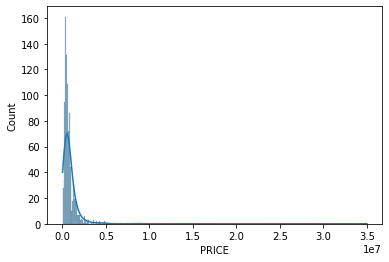

In [26]:
price_dist = sns.histplot(data = LDF[LDF["PROPERTY_TYPE"] != "Vacant Land"], x = "PRICE", kde = True)

In [27]:
price = LDF["PRICE"] < 2000000

In [28]:
price

0       True
1       True
2       True
3       True
4       True
        ... 
1141    True
1142    True
1143    True
1144    True
1145    True
Name: PRICE, Length: 1146, dtype: bool

In [29]:
# Getting rid of outliers 
tester = LDF[LDF["PROPERTY_TYPE"] != "Vacant Land"]

tester1 = tester[tester["PRICE"] < 2000000]
tester1.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 938 entries, 0 to 1145
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ADDRESS            938 non-null    object 
 1   PRICE              938 non-null    int64  
 2   BEDROOMS           905 non-null    float64
 3   BATHS              908 non-null    float64
 4   SQUARE_FT          924 non-null    float64
 5   TOTAL_TIME_LISTED  936 non-null    object 
 6   PROPERTY_TYPE      938 non-null    object 
 7   YEAR_BUILT         868 non-null    float64
 8   HOA_DUES           254 non-null    float64
 9   COMMUNITY          934 non-null    object 
 10  LOT_SIZE           858 non-null    object 
 11  PRICE_PER_SQFT     907 non-null    float64
dtypes: float64(6), int64(1), object(5)
memory usage: 95.3+ KB


In [30]:
tester2 = tester1[tester1["SQUARE_FT"] < 5000]

In [31]:
tester3 = tester2[tester2["BATHS"] >= 1]

In [32]:
tester4 = tester3[tester2["BEDROOMS"] >= 1]

/var/folders/c3/70y7ct457z7_9cv9bcgyx8sc0000gn/T/ipykernel_1026/2131888859.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  tester4 = tester3[tester2["BEDROOMS"] >= 1]


In [33]:
tester4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 1145
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ADDRESS            891 non-null    object 
 1   PRICE              891 non-null    int64  
 2   BEDROOMS           891 non-null    float64
 3   BATHS              891 non-null    float64
 4   SQUARE_FT          891 non-null    float64
 5   TOTAL_TIME_LISTED  890 non-null    object 
 6   PROPERTY_TYPE      891 non-null    object 
 7   YEAR_BUILT         845 non-null    float64
 8   HOA_DUES           243 non-null    float64
 9   COMMUNITY          887 non-null    object 
 10  LOT_SIZE           823 non-null    object 
 11  PRICE_PER_SQFT     891 non-null    float64
dtypes: float64(6), int64(1), object(5)
memory usage: 90.5+ KB


In [34]:
tester4

,ADDRESS,PRICE,BEDROOMS,BATHS,SQUARE_FT,TOTAL_TIME_LISTED,PROPERTY_TYPE,YEAR_BUILT,HOA_DUES,COMMUNITY,LOT_SIZE,PRICE_PER_SQFT
0,11643 Silvergate Dr,1690000,4.0,2.0,1888.0,23 hours,Single Family Residential,1968.0,NaN,DUBLIN,"7,153 Sq. Ft.",895.0
1,7806 Peachtree Ave,1249888,3.0,2.5,1356.0,26 hours,Single Family Residential,1971.0,NaN,NEWARK,"6,000 Sq. Ft.",922.0
2,38746 Buckboard Cmn,1298000,3.0,2.5,1780.0,2 days,Single Family Home,1988.0,91.0,FREMONT,"3,348 Sq. Ft.",729.0
3,564 Olivina Ave,850000,4.0,2.0,1268.0,2 days,Single Family Residential,1971.0,NaN,LIVERMORE,"7,224 Sq. Ft.",670.0
4,1970 Barton Way,1125000,4.0,2.5,1751.0,3 days,Single Family Residential,1992.0,NaN,HAYWARD,"3,500 Sq. Ft.",642.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1141,26527 Chambers Ave,439900,2.0,2.0,1508.0,3 days,Single Family Residence,1973.0,33.0,SRCAR - SOUTHWEST RIVERSIDE COUNTY,"6,970 Sq. Ft.",292.0
1142,30644 Ticonderoga Ct,669900,3.0,2.5,1864.0,3 days,Single Family Residence,2018.0,100.0,SRCAR - SOUTHWEST RIVERSIDE COUNTY,"3,049 Sq. Ft.",359.0
1143,78058 Red Hawk Ln,1499999,4.0,4.5,3349.0,3 days,Single Family Residence,2005.0,294.0,313 - LA QUINTA SOUTH OF HWY 111,0.25 Acres,448.0
1144,38977 Lone Cir,599900,4.0,2.5,2091.0,3 days,Single Family Residence,2003.0,40.0,699 - NOT DEFINED,"4,356 Sq. Ft.",287.0


In [35]:
tester4["HOA_DUES"].fillna('MISSING', inplace = True)

/var/folders/c3/70y7ct457z7_9cv9bcgyx8sc0000gn/T/ipykernel_1026/2090861413.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tester4["HOA_DUES"].fillna('MISSING', inplace = True)


In [36]:
# Creating a dummy variable where 1 if a house has no HOA fees and 0 if a house does have HOA fees.
tester4["HOA_DUES"] = (tester4["HOA_DUES"] == "MISSING").astype(int)
tester4["HOA_DUES"]

/var/folders/c3/70y7ct457z7_9cv9bcgyx8sc0000gn/T/ipykernel_1026/37448945.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tester4["HOA_DUES"] = (tester4["HOA_DUES"] == "MISSING").astype(int)


0       1
1       1
2       0
3       1
4       1
       ..
1141    0
1142    0
1143    0
1144    0
1145    0
Name: HOA_DUES, Length: 891, dtype: int64

In [37]:
tester4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 0 to 1145
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ADDRESS            891 non-null    object 
 1   PRICE              891 non-null    int64  
 2   BEDROOMS           891 non-null    float64
 3   BATHS              891 non-null    float64
 4   SQUARE_FT          891 non-null    float64
 5   TOTAL_TIME_LISTED  890 non-null    object 
 6   PROPERTY_TYPE      891 non-null    object 
 7   YEAR_BUILT         845 non-null    float64
 8   HOA_DUES           891 non-null    int64  
 9   COMMUNITY          887 non-null    object 
 10  LOT_SIZE           823 non-null    object 
 11  PRICE_PER_SQFT     891 non-null    float64
dtypes: float64(5), int64(2), object(5)
memory usage: 90.5+ KB


In [38]:
# Setting up dummy variables for property type
tester4["PROPERTY_TYPE"].value_counts()

Single Family Residential                   359
Single Family Residence                     170
Condo                                        81
Residential                                  67
Mobile/Manufactured Home                     42
Single Family Home                           38
Residential, Single Family                   36
Single Family                                22
Multi-Family (2-4 Unit)                      19
Townhouse                                    19
Manufactured on Land                         13
Duplex                                        5
Single Family Detached                        4
Residential, Forest Service Cabin             2
Residential, Share Ownership                  2
Apartment                                     2
Cabin                                         2
Condominium                                   1
Townhouse, Residential Condo/Co-Op            1
Multi Family                                  1
Multi-Family (5+ Unit)                  

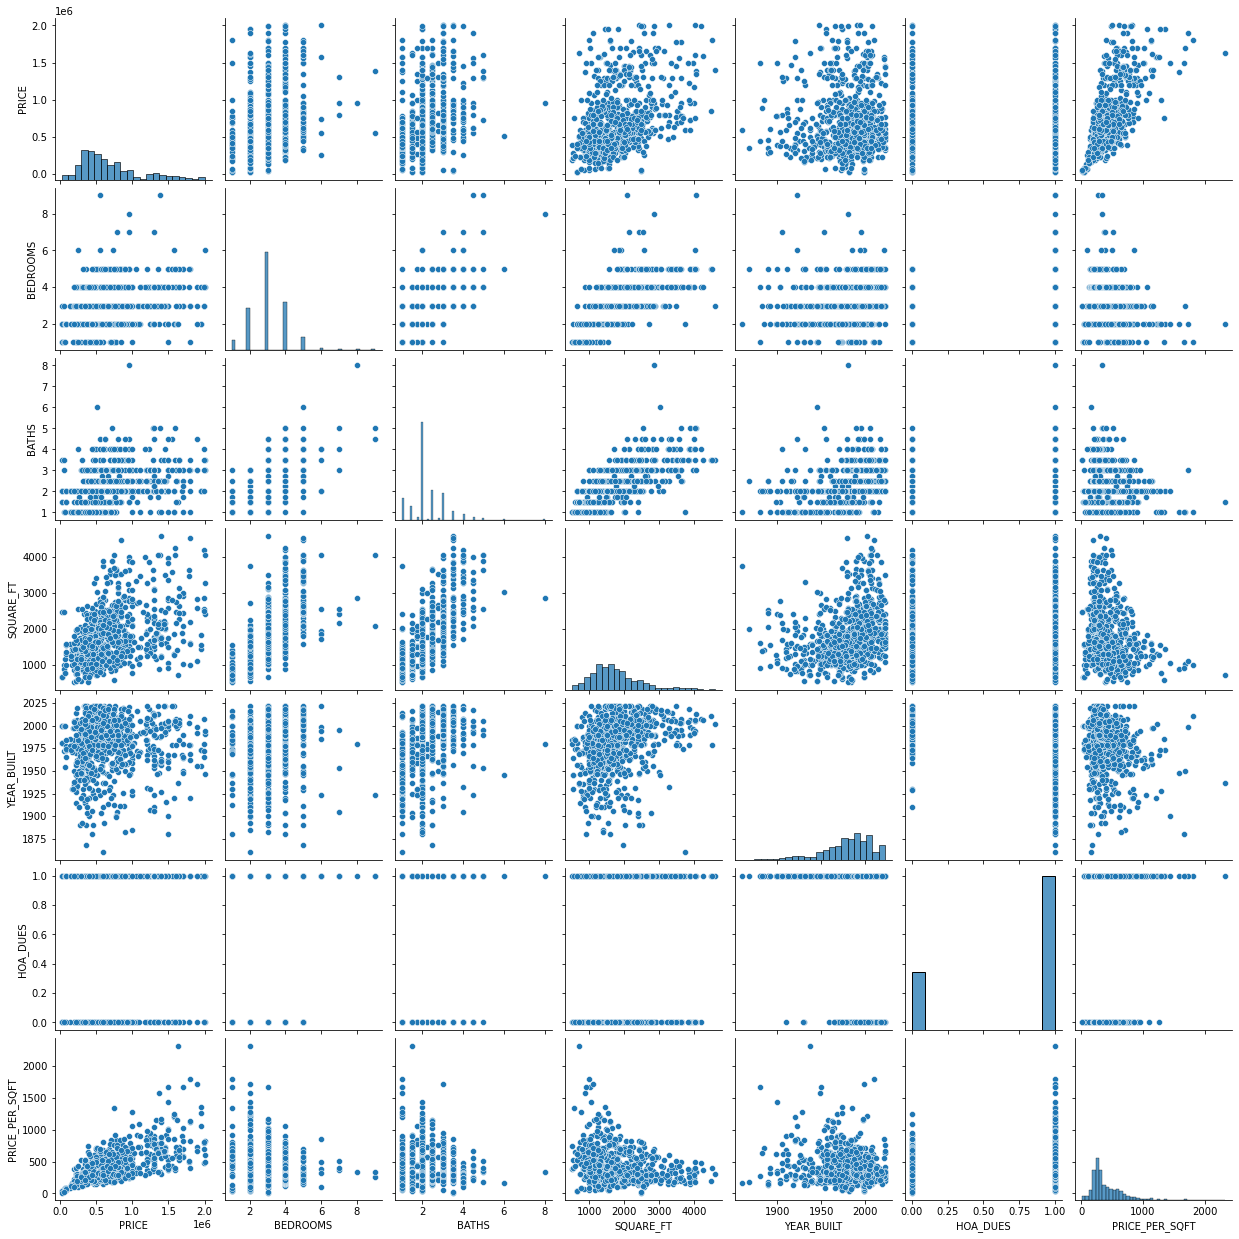

In [206]:
# From initial pair plot it seems like "HOA dues" and "year built" do not have a linear correlation with "price".
# Factors that have the some correlation are number of "bedrooms", "baths", "square_ft", and "price per sqft"
# Models will be built from these features chosen. 
# Pair plot also tells us where outliers in our data are. Will get rid of these data points 
ax = sns.pairplot(tester4)

<AxesSubplot:xlabel='SQUARE_FT', ylabel='Count'>

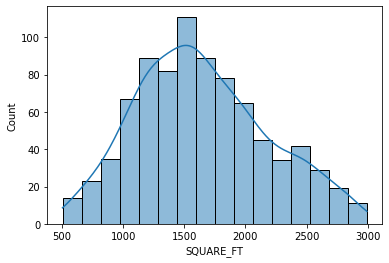

In [112]:
sns.histplot(data = tester4_filtered, x = "SQUARE_FT", kde = True)

<AxesSubplot:xlabel='SQUARE_FT', ylabel='PRICE'>

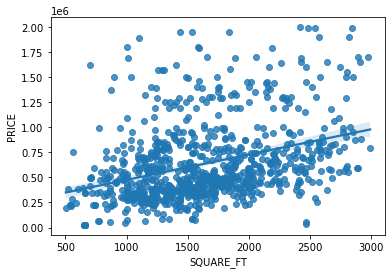

In [113]:
sns.regplot(x = 'SQUARE_FT', y = 'PRICE', data = tester4_filtered)

Text(0.5, 1.0, 'Normal Q-Q plot')

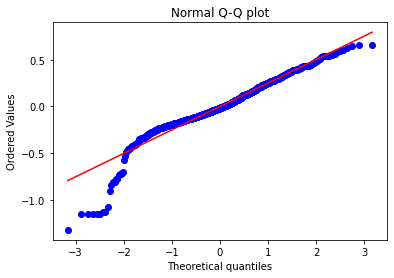

In [49]:
stats.probplot(residuals1, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")

In [84]:
# Setting up a test train val split 
X, X_test, y, y_test = train_test_split(tester4[['HOA_DUES','PROPERTY_TYPE','LOT_SIZE',
                                                 'ADDRESS',"PRICE_PER_SQFT","YEAR_BUILT",'BEDROOMS','BATHS',
                                                 'SQUARE_FT']], tester4['PRICE'], 
                                                    test_size=0.2, 
                                                    random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.25, random_state = 3)

In [263]:
X_test

,HOA_DUES,PROPERTY_TYPE,LOT_SIZE,ADDRESS,PRICE_PER_SQFT,YEAR_BUILT,BEDROOMS,BATHS,SQUARE_FT
746,0,Single Family Residential,"5,001 Sq. Ft.",1077 W California Ave,1250.0,54.000000,2.0,1.0,1260.0
161,1,Single Family Residential,0.65 Acres,3697 Big Foot Cir,419.0,50.000000,2.0,1.0,832.0
806,1,Single Family Residence,0.89 Acres,2414 Golden Ct,233.0,40.000000,3.0,2.0,1716.0
242,0,Single Family Residential,"2,442 Sq. Ft.",1103 Yarrow Pl,446.0,21.000000,4.0,2.5,1603.0
282,0,Condo,574 Sq. Ft.,920 Balbijou Rd #233,911.0,50.000000,1.0,2.0,834.0
...,...,...,...,...,...,...,...,...,...
566,1,Residential,"5,998 Sq. Ft.",957 Burlwood Ave,203.0,32.000000,3.0,2.0,1649.0
238,1,Single Family Residential,"4,440 Sq. Ft.",3094 Delano Dr,343.0,2.000000,5.0,3.0,2770.0
762,0,Single Family Residential,"7,092 Sq. Ft.",27 Palmer Dr,490.0,19.000000,4.0,3.0,3634.0
120,1,Single Family Residence,"5,227 Sq. Ft.",2809 Dolphin Bend Dr,272.0,7.000000,3.0,2.0,2007.0


In [85]:
# Working with only the train data.
X_train

,HOA_DUES,PROPERTY_TYPE,LOT_SIZE,ADDRESS,PRICE_PER_SQFT,YEAR_BUILT,BEDROOMS,BATHS,SQUARE_FT
573,1,Single Family Residential,40 Acres,7661 Highway 29,889.0,1975.0,3.0,3.0,1406.0
924,1,Single Family,0.44 Acres,85 Summit St,436.0,1979.0,5.0,4.5,3570.0
283,1,"Residential, Single Family","9,583 Sq. Ft.",1372 Donner Ln,536.0,2007.0,4.0,3.0,2330.0
588,1,Single Family Residential,2.78 Acres,19810 Jaclyn Dr,317.0,2018.0,4.0,4.0,3869.0
672,1,Condo,"7,517 Sq. Ft.",1818 Speyer Ln Unit B,674.0,1993.0,4.0,2.5,2149.0
...,...,...,...,...,...,...,...,...,...
513,1,"Residential, Single Family","8,712 Sq. Ft.",3200 Olympic Dr,185.0,1962.0,3.0,2.5,1720.0
141,0,Single Family Residence,"6,534 Sq. Ft.",35 Hampshire Dr,363.0,1986.0,2.0,2.0,1034.0
540,1,Single Family Residential,"7,770 Sq. Ft.",999 Tranquility Ct,186.0,2009.0,4.0,3.0,2679.0
800,1,Single Family Residence,"9,547 Sq. Ft.",7515 Henness Cir,552.0,1984.0,1.0,1.5,1535.0


In [86]:
# Changing the year built to house age, was having error with the building a model that included just the year 
X_train["YEAR_BUILT"] = 2022 - X_train["YEAR_BUILT"]
X_train

,HOA_DUES,PROPERTY_TYPE,LOT_SIZE,ADDRESS,PRICE_PER_SQFT,YEAR_BUILT,BEDROOMS,BATHS,SQUARE_FT
573,1,Single Family Residential,40 Acres,7661 Highway 29,889.0,47.0,3.0,3.0,1406.0
924,1,Single Family,0.44 Acres,85 Summit St,436.0,43.0,5.0,4.5,3570.0
283,1,"Residential, Single Family","9,583 Sq. Ft.",1372 Donner Ln,536.0,15.0,4.0,3.0,2330.0
588,1,Single Family Residential,2.78 Acres,19810 Jaclyn Dr,317.0,4.0,4.0,4.0,3869.0
672,1,Condo,"7,517 Sq. Ft.",1818 Speyer Ln Unit B,674.0,29.0,4.0,2.5,2149.0
...,...,...,...,...,...,...,...,...,...
513,1,"Residential, Single Family","8,712 Sq. Ft.",3200 Olympic Dr,185.0,60.0,3.0,2.5,1720.0
141,0,Single Family Residence,"6,534 Sq. Ft.",35 Hampshire Dr,363.0,36.0,2.0,2.0,1034.0
540,1,Single Family Residential,"7,770 Sq. Ft.",999 Tranquility Ct,186.0,13.0,4.0,3.0,2679.0
800,1,Single Family Residence,"9,547 Sq. Ft.",7515 Henness Cir,552.0,38.0,1.0,1.5,1535.0


<AxesSubplot:xlabel='YEAR_BUILT', ylabel='Count'>

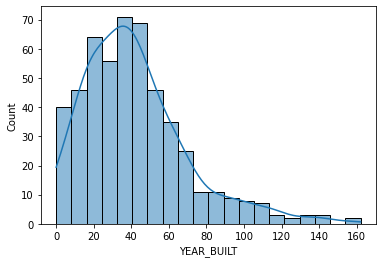

In [87]:
sns.histplot(data = X_train, x = "YEAR_BUILT", kde = True)

In [88]:
X_train["YEAR_BUILT"].fillna(0, inplace = True)
X_train["YEAR_BUILT"] = X_train["YEAR_BUILT"].replace(0, X_train["YEAR_BUILT"].mean())

In [89]:
m1 = LinearRegression()
m1.fit(X_train[['HOA_DUES','BEDROOMS','BATHS','SQUARE_FT']],y_train)
print("m1.score(X_train[['HOA_DUES','BEDROOMS','BATHS','SQUARE_FT']],y_train)

0.21362361837128185

In [90]:
yln = np.log(y_train)

In [248]:
m2 = LinearRegression()
m2.fit(X_train[['HOA_DUES','BEDROOMS','BATHS','SQUARE_FT']],yln)
print("R2 value:" ,m2.score(X_train[['HOA_DUES','BEDROOMS','BATHS','SQUARE_FT']],yln))

R2 value: 0.2255843434027146


Text(0, 0.5, 'Residual')

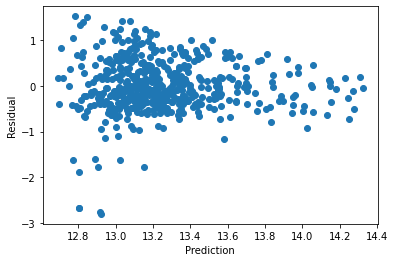

In [92]:
X_train_predict = m2.predict(X_train[['HOA_DUES','BEDROOMS','BATHS','SQUARE_FT']])
X_train_resid = (yln - X_train_predict)
fig = plt.scatter(X_train_predict,X_train_resid)
fig.axes.set_xlabel("Prediction")
fig.axes.set_ylabel("Residual")

Text(0.5, 1.0, 'Normal Q-Q plot')

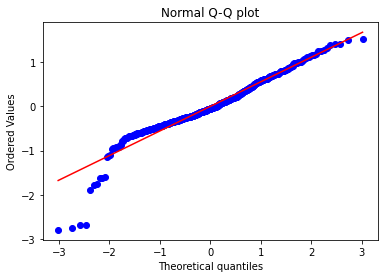

In [93]:
stats.probplot(X_train_resid, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")

In [251]:
m3 = LinearRegression()
m3.fit(X_train[['HOA_DUES','BEDROOMS','BATHS','SQUARE_FT','YEAR_BUILT']],y_train)
print("Train R2 Value:",m3.score(X_train[['HOA_DUES','BEDROOMS','BATHS','SQUARE_FT','YEAR_BUILT']],y_train))

Train R2 Value: 0.24556157952873436


In [95]:
# Working on Validation data to see if it's overfitting 
X_val["YEAR_BUILT"] = 2022 - X_val["YEAR_BUILT"]
X_val["YEAR_BUILT"].fillna(0, inplace = True)
X_val["YEAR_BUILT"] = X_val["YEAR_BUILT"].replace(0, X_val["YEAR_BUILT"].mean())
yln_val = np.log(y_val)
X_val

,HOA_DUES,PROPERTY_TYPE,LOT_SIZE,ADDRESS,PRICE_PER_SQFT,YEAR_BUILT,BEDROOMS,BATHS,SQUARE_FT
145,0,Single Family Residence,"5,663 Sq. Ft.",533 Mission Santa Fe Cir,328.0,23.0,3.0,2.0,1493.0
497,1,Single Family Residence,1.26 Acres,2895 59th St W,298.0,29.0,3.0,2.0,1576.0
652,1,Single Family Residence,"2,500 Sq. Ft.",3500 S Denison Ave,545.0,14.0,3.0,2.5,2200.0
1006,1,Single Family Residential,10.36 Acres,123 Deer Run Ln N,534.0,33.0,1.0,1.0,1312.0
721,1,Residential,"7,475 Sq. Ft.",116 Autumn Rd,264.0,57.0,3.0,2.0,1422.0
...,...,...,...,...,...,...,...,...,...
610,0,Manufactured on Land,0.55 Acres,13491 Anchor,284.0,31.0,3.0,2.0,1300.0
1065,1,Single Family Residence,"6,600 Sq. Ft.",5765 Honduras Way,539.0,65.0,4.0,2.0,1669.0
254,0,Single Family Residential,"3,424 Sq. Ft.",2644 Longview Dr,294.0,37.0,3.0,2.5,2516.0
307,1,Residential,"4,335 Sq. Ft.",3564 Bellaire Ave,245.0,8.0,4.0,3.5,2245.0


<AxesSubplot:xlabel='PRICE', ylabel='Count'>

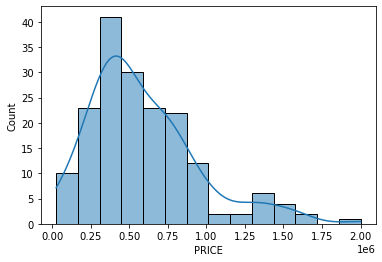

In [96]:
sns.histplot(data = y_val, kde = True)

<AxesSubplot:xlabel='PRICE', ylabel='Count'>

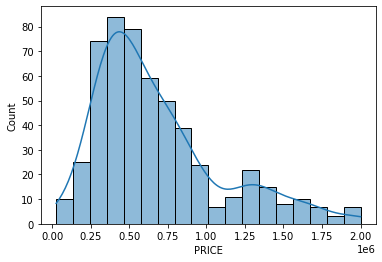

In [97]:
sns.histplot(data = y_train, kde = True)

In [253]:
print("Train R2 Value:",m3.score(X_train[['HOA_DUES','BEDROOMS','BATHS','SQUARE_FT','YEAR_BUILT']],y_train))
print("Val R2 Value:",m3.score(X_val[['HOA_DUES','BEDROOMS','BATHS','SQUARE_FT','YEAR_BUILT']],y_val))
# Seems like we're overfitting lets run LassoCv

Train R2 Value: 0.24556157952873436
Val R2 Value: 0.09524071078051277


In [99]:
# Checking for collinearity 
from statsmodels.stats.outliers_influence import variance_inflation_factor
X_train_feats = X_train[['HOA_DUES','BEDROOMS','BATHS','SQUARE_FT','YEAR_BUILT']]
vif = pd.DataFrame()
vif['variables'] = X_train_feats.columns
vif['vif'] =[variance_inflation_factor(X_train_feats.values, i) for i in range(X_train_feats.shape[1])]
vif

,variables,vif
0,HOA_DUES,4.258678
1,BEDROOMS,19.571927
2,BATHS,18.521948
3,SQUARE_FT,15.241268
4,YEAR_BUILT,3.092823


In [100]:
# Standardizing data with sklearn to prep data for Lasso reg
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LassoCV, RidgeCV
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[['HOA_DUES','BEDROOMS','BATHS','SQUARE_FT','YEAR_BUILT']])


In [101]:
kfold = KFold(n_splits=5, shuffle=True, random_state=0)
params = {"alpha": np.logspace(-4, -.1, 20)}
grid_est = GridSearchCV(Lasso(), param_grid=params, cv=kfold, 
                        return_train_score=False)
grid_est.fit(X_train[['HOA_DUES','BEDROOMS','BATHS','SQUARE_FT','YEAR_BUILT']], y_train)
grid_est.best_estimator_

Lasso(alpha=0.0001)

In [102]:
lasso = Lasso(alpha = 0.0001)
lasso.fit(X_train[['HOA_DUES','BEDROOMS','BATHS','SQUARE_FT','YEAR_BUILT']], y_train)
lasso.score(X_train[['HOA_DUES','BEDROOMS','BATHS','SQUARE_FT','YEAR_BUILT']], y_train)

0.24556157952873436

In [230]:

mae = sum(abs(m3.predict(X_val[['HOA_DUES','BEDROOMS','BATHS','SQUARE_FT','YEAR_BUILT']]) - y_val))/len(y_val)
print("LR Val MAE:",mae)

residuals2 = m3.predict(X_val[['HOA_DUES','BEDROOMS','BATHS','SQUARE_FT','YEAR_BUILT']]) - y_val
rmse = np.sqrt(sum(residuals2**2)/len(residuals2))
print("LR Val RMSE:",rmse)

LR Val MAE: 257911.58373302832
LR Val RMSE: 335709.7318502675


Text(0, 0.5, 'Residual')

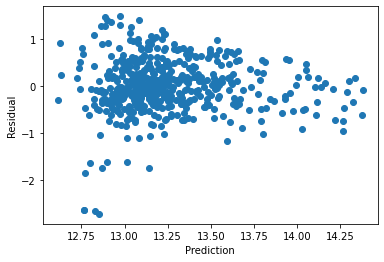

In [72]:
X_train_predict2 = m3.predict(X_train[['HOA_DUES','BEDROOMS','BATHS','SQUARE_FT','YEAR_BUILT']])
X_train_resid2 = (yln - X_train_predict2)
fig = plt.scatter(X_train_predict2,X_train_resid2)
fig.axes.set_xlabel("Prediction")
fig.axes.set_ylabel("Residual")

Text(0.5, 1.0, 'Normal Q-Q plot')

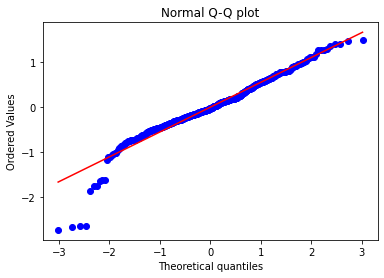

In [73]:
stats.probplot(X_train_resid2, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")

Text(0, 0.5, 'Residual')

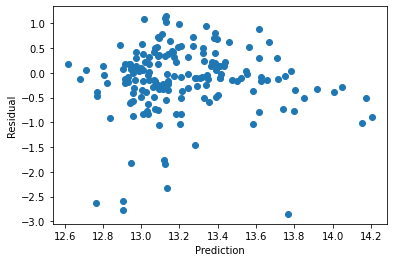

In [77]:
X_val_predict = m3.predict(X_val[['HOA_DUES','BEDROOMS','BATHS','SQUARE_FT','YEAR_BUILT']])
X_val_resid = (yln_val - X_val_predict)
fig = plt.scatter(X_val_predict,X_val_resid)
fig.axes.set_xlabel("Prediction")
fig.axes.set_ylabel("Residual")

Text(0.5, 1.0, 'Normal Q-Q plot')

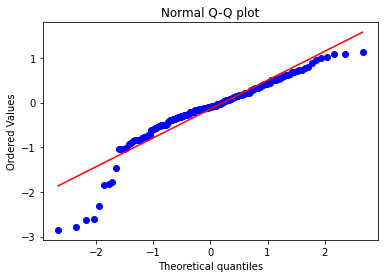

In [78]:
stats.probplot(X_val_resid, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")

In [116]:
# Attempting to drop houses that are too large 
X1, X1_test, y1, y1_test = train_test_split(tester4_filtered[['HOA_DUES','PROPERTY_TYPE','LOT_SIZE',
                                                 'ADDRESS',"PRICE_PER_SQFT","YEAR_BUILT",'BEDROOMS','BATHS',
                                                 'SQUARE_FT']], tester4_filtered['PRICE'], 
                                                    test_size=0.2, 
                                                    random_state=10)
X1_train, X1_val, y1_train, y1_val = train_test_split(X1, y1, test_size = 0.25, random_state = 3)

In [119]:
X1_train["YEAR_BUILT"] = 2022 - X1_train["YEAR_BUILT"]
X1_train["YEAR_BUILT"].fillna(0, inplace = True)
X1_train["YEAR_BUILT"] = X1_train["YEAR_BUILT"].replace(0, X1_train["YEAR_BUILT"].mean())
y1log = np.log(y1_train)

In [120]:
m5 = LinearRegression()
m5.fit(X1_train[['HOA_DUES','BEDROOMS','BATHS','SQUARE_FT','YEAR_BUILT']],y1log)
m5.score(X1_train[['HOA_DUES','BEDROOMS','BATHS','SQUARE_FT','YEAR_BUILT']],y1log)

0.14230581832336242

In [124]:
mae2 = sum(abs(m5.predict(X1_train[['HOA_DUES','BEDROOMS','BATHS','SQUARE_FT','YEAR_BUILT']]) - y1_train))/len(y1_train)
print(mae2)

633041.3057619082


In [121]:
X1_val["YEAR_BUILT"] = 2022 - X1_val["YEAR_BUILT"]
X1_val["YEAR_BUILT"].fillna(0, inplace = True)
X1_val["YEAR_BUILT"] = X1_val["YEAR_BUILT"].replace(0, X1_val["YEAR_BUILT"].mean())
y1log_val = np.log(y1_val)

In [122]:
m5.score(X1_val[['HOA_DUES','BEDROOMS','BATHS','SQUARE_FT','YEAR_BUILT']],y1log_val)

-64.13661633320056

In [125]:
mae3 = sum(abs(m5.predict(X1_val[['HOA_DUES','BEDROOMS','BATHS','SQUARE_FT','YEAR_BUILT']]) - y1_val))/len(y1_val)
print(mae)

586929.0575288134


Changing the parameters for the data entered made the model worse will revert back to old data

Trying to use polynomial features to see if it improves scoring

In [129]:
from sklearn.preprocessing import PolynomialFeatures

In [140]:
poly = PolynomialFeatures(degree=2)
X_train_poly = poly.fit_transform(X_train[['HOA_DUES','BEDROOMS','BATHS','SQUARE_FT','YEAR_BUILT']])
X_val_poly = poly.transform(X_val[['HOA_DUES','BEDROOMS','BATHS','SQUARE_FT','YEAR_BUILT']])

In [235]:
logy = np.log(y_train)

In [219]:
lr_poly = LinearRegression()
lr_poly.fit(X_train_poly,y_train)
print("Train R2:",lr_poly.score(X_train_poly,y_train))
trainpoly_mae = sum(abs(lr_poly.predict(X_train_poly) - y_train))/len(y_train)
print("Train MAE:",trainpoly_mae)

Train R2: 0.2860416613805472
Train MAE: 263529.6299082439


Text(0, 0.5, 'Residual')

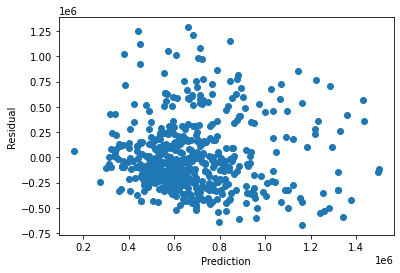

In [233]:
lrpoly_train_predict = lr_poly.predict(X_train_poly)
lrpoly_resid = (y_train - lrpoly_train_predict)
figpoly = plt.scatter(lrpoly_train_predict,lrpoly_resid)
figpoly.axes.set_xlabel("Prediction")
figpoly.axes.set_ylabel("Residual")

Text(0.5, 1.0, 'Normal Q-Q plot')

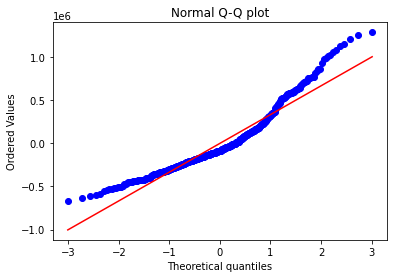

In [234]:
stats.probplot(lrpoly_resid, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")

In [256]:
print("Val R2:",lr_poly.score(X_val_poly, y_val))
valpoly_mae = sum(abs(lr_poly.predict(X_val_poly) - y_val))/len(y_val)
print("Val MAE:",valpoly_mae)

Val R2: -2.76551661079176
Val MAE: 586929.0548352428


In [143]:
# Overfitting is occuring so will try lasso 
polyscaler = StandardScaler()
X_train_poly_scaled = polyscaler.fit_transform(X_train_poly)
X_val_poly_scaled = polyscaler.transform(X_val_poly)

In [144]:
polylasso = LassoCV()
polylasso.fit(X_train_poly_scaled,y_train)
polylasso.score(X_train_poly_scaled,y_train)
trainpolylasso_mae = sum(abs(lr_poly.predict(X_train_poly) - y_train))/len(y_train)
print(trainpolylasso_mae)

0.24403763543462476

In [145]:
polylasso.score(X_val_poly_scaled, y_val)

0.10298492716235896

In [202]:
polyridge = RidgeCV(alphas = 2000)
polyridge.fit(X_train_poly_scaled,y_train)
print("R2 for the train data:",polyridge.score(X_train_poly_scaled,y_train))
print("R2 for the val data:",polyridge.score(X_val_poly_scaled,y_val))


R2 for the train data: 0.18228219188222938
R2 for the val data: 0.07024285252655227


In [220]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score
rf = RandomForestRegressor(n_estimators=2000, max_features=3, max_depth=5)
rf.fit(X_train_poly_scaled, y_train)
y_pred = rf.predict(X_val_poly_scaled)
print("Random Forest Regression:", r2_score(y_val, y_pred))
print("R2 for the train data:",rf.score(X_train_poly_scaled, y_train))
rfpoly_mae = sum(abs(rf.predict(X_val_poly_scaled) - y_val))/len(y_val)
print("RF MAE:",rfpoly_mae)

Random Forest Regression: 0.11428453524790083
R2 for the train data: 0.4619591986381608
RF MAE: 257582.83659502785


Text(0, 0.5, 'Residual')

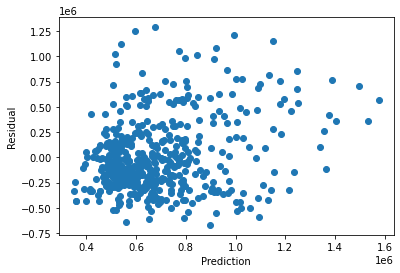

In [243]:
rf_train_predict = rf.predict(X_train_poly_scaled)
rf_resid = (y_train - lrpoly_train_predict)
figrf = plt.scatter(rf_train_predict,rf_resid)
figrf.axes.set_xlabel("Prediction")
figrf.axes.set_ylabel("Residual")

Text(0.5, 1.0, 'Normal Q-Q plot')

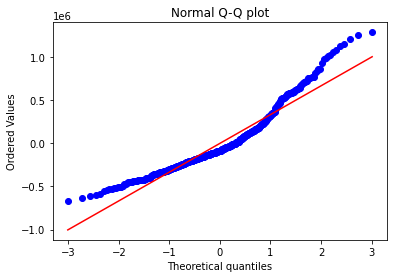

In [244]:
stats.probplot(rf_resid, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")

In [ ]:
stats.probplot(lrpoly_resid, dist="norm", plot=plt)
plt.title("Normal Q-Q plot")

In [222]:
gbm1 = GradientBoostingRegressor(n_estimators=500, max_depth=3, learning_rate=.01)
gbm1.fit(X_train_poly_scaled, y_train)
ygbm1_pred = gbm1.predict(X_val_poly_scaled)
print("Gradient Boosted Regression:", r2_score(y_val, ygbm1_pred))
print("R2 for the train data:",gbm1.score(X_train_poly_scaled, y_train))
gbm2poly_mae = sum(abs(ygbm1_pred - y_val))/len(y_val)
print("GBM2 MAE:",gbm2poly_mae)


Gradient Boosted Regression: 0.09515474982338112
R2 for the train data: 0.5466839256563354
GBM2 MAE: 251714.0565691733


__This is the best performed model so far let's try it on our test data__

In [147]:
X_test["YEAR_BUILT"] = 2022 - X_test["YEAR_BUILT"]
X_test["YEAR_BUILT"].fillna(0, inplace = True)
X_test["YEAR_BUILT"] = X_test["YEAR_BUILT"].replace(0, X_test["YEAR_BUILT"].mean())

In [148]:
X_test_poly = poly.transform(X_test[['HOA_DUES','BEDROOMS','BATHS','SQUARE_FT','YEAR_BUILT']])

In [149]:
lr_poly.score(X_test_poly, y_test)

0.18741916261337743

In [214]:
polytest1_mae = sum(abs(lr_poly.predict(X_test_poly) - y_test))/len(y_test)
print(polytest1_mae)

277842.0644312086


In [203]:
X_test_poly_scaled = polyscaler.transform(X_test_poly)

In [213]:
polylasso.score(X_test_poly_scaled,y_test)


0.1778883506966783

In [262]:
print("R2 for the test data:",gbm1.score(X_test_poly_scaled, y_test))

R2 for the test data: 0.18181100604507805


In [257]:
y_predtest = rf.predict(X_test_poly_scaled)
print("Random Forest Regression:", r2_score(y_test, y_predtest))

Random Forest Regression: 0.2005845526196427


In [260]:
lrtest_mae = sum(abs(lr_poly.predict(X_test_poly) - y_test))/len(y_test)
print("LRtest MAE:",lrtest_mae)
polytest1_mae = sum(abs(lr_poly.predict(X_test_poly) - y_test))/len(y_test)
print("Polytest MAE:",polytest1_mae)
rftestpoly_mae = sum(abs(rf.predict(X_test_poly_scaled) - y_test))/len(y_test)
print("RFtest MAE:",rftestpoly_mae)
gbm1testpoly_mae = sum(abs(gbm1.predict(X_test_poly) - y_test))/len(y_test)
print("GBM1test MAE:",gbm1testpoly_mae)
gbm2testpoly_mae = sum(abs(gbm1.predict(X_test_poly_scaled) - y_test))/len(y_test)
print("GBM2test MAE:",gbm2testpoly_mae)

LRtest MAE: 717587.7434494821
Polytest MAE: 717587.7434494821
RFtest MAE: 276833.597968651
GBM1test MAE: 665056.0934653465
GBM2test MAE: 281015.108491113
